# 56_RNN - 감성분석

# 감성분석
### 감성분석 Sentiment Analysis
- 입력된 자연어 안의 주관적 의견, 감정 등을 찾아내는 문제
- 이중 문장의 긍정/부정 등을 구분하는 경우가 많음

In [3]:
train_text = open('./dataset/nsmc/ratings_train.txt', 'rb').read().decode(encoding='utf-8')
                                    # rb : r = open for reading / b = binary mode
test_text = open('./dataset/nsmc/ratings_test.txt', 'rb').read().decode(encoding='utf-8')

print('Length of text : {} characters'.format(len(train_text)))
print('Length of text : {} characters'.format(len(test_text)))
print()

print(train_text[:300])

Length of text : 6937271 characters
Length of text : 2318260 characters

id	document	label
9976970	아 더빙.. 진짜 짜증나네요 목소리	0
3819312	흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나	1
10265843	너무재밓었다그래서보는것을추천한다	0
9045019	교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정	0
6483659	사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다	1
5403919	막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.	0
7797314	원작의


In [4]:
train_text[:300]

'id\tdocument\tlabel\n9976970\t아 더빙.. 진짜 짜증나네요 목소리\t0\n3819312\t흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나\t1\n10265843\t너무재밓었다그래서보는것을추천한다\t0\n9045019\t교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정\t0\n6483659\t사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다\t1\n5403919\t막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.\t0\n7797314\t원작의'

> ## \t, \n 등이 있다.

------------
# 데이터 전처리

In [5]:
# 1 줄바꿈 (\n)
train_text.split('\n')[:3]

['id\tdocument\tlabel',
 '9976970\t아 더빙.. 진짜 짜증나네요 목소리\t0',
 '3819312\t흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나\t1']

In [6]:
# 2 탭 문자 ('\t')
train_text.split('\n')[3].split('\t')

['10265843', '너무재밓었다그래서보는것을추천한다', '0']

In [7]:
import numpy as np 

train_Y = np.array([[int(row.split('\t')[2])] for row in train_text.split('\n')[1:] if row.count('\t') > 0])
                                                        # train_text.split('\n')[0] = 'id\tdocument\tlabel'
                                                                                        # row : ['9976970\t아 더빙.. 진짜 짜증나네요 목소리\t0', '3819312\t흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나\t1', ... ]
test_Y = np.array([[int(row.split('\t')[2])] for row in test_text.split('\n')[1:] if row.count('\t') > 0])

print(train_Y.shape, test_Y.shape)
print(train_Y[:5])      # label print

(150000, 1) (50000, 1)
[[0]
 [1]
 [0]
 [0]
 [1]]


-----------------
# tokenization 와 cleaning
- ### `tokenization` : 자연어를 처리 가능한 최소의 단위로 나누는 것으로 여기서는 띄어쓰기로 한다.
- ### `cleaning` : 불필요한 기호를 제거하는 것

In [9]:
# 1 cleaning 함수

## 문장을 띄워서 분류할 예정
import re

def clean_str(string):
    string = re.sub(r"[^가-힣A-Za-z0-9(),!?\'\`]", " ", string)
                        # 바꿔야 할 리스트
                                                    # 바뀌게 될 문장

    string = re.sub(r"\'s", " \'s", string)         # He 's
    string = re.sub(r"\'ve", " \'ve", string)       # I 've
    string = re.sub(r"n\'t", " n\'t", string)       # He can 't
    string = re.sub(r"\'re", " \'re", string)       # you 're
    string = re.sub(r"\'d", " \'d", string)         # I 'd
    string = re.sub(r"\'ll", " \'ll", string)       # they 'll
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)     # \s{2,} : white spaces, 공백이 {2,} 2개 이상인 경우 >> ' ' 하나만 표현
    string = re.sub(r"\'{2,}", "\'", string)    # \'{2,} : '이 {2,} 2개 이상인 경우 >> ' 하나만 표현
    string = re.sub(r"\'", "", string)          # \' : ' 이 1개만 있는 경우 >> 공란으로 표현

    return string.lower()

------------------------

In [10]:
# 훈련용 데이터 전처리 완료
train_text_X = [row.split('\t')[1] for row in train_text.split('\n')[1:] if row.count('\t') > 0]
train_text_X = [clean_str(sentence) for sentence in train_text_X]

sentences = [sentence.split(' ') for sentence in train_text_X]
for i in range(5):
    print(sentences[i])

['아', '더빙', '진짜', '짜증나네요', '목소리']
['흠', '포스터보고', '초딩영화줄', '오버연기조차', '가볍지', '않구나']
['너무재밓었다그래서보는것을추천한다']
['교도소', '이야기구먼', '솔직히', '재미는', '없다', '평점', '조정']
['사이몬페그의', '익살스런', '연기가', '돋보였던', '영화', '!', '스파이더맨에서', '늙어보이기만', '했던', '커스틴', '던스트가', '너무나도', '이뻐보였다']


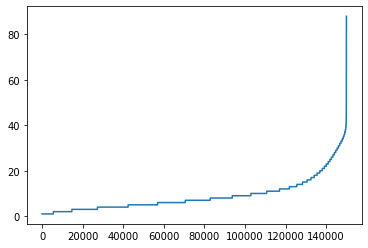

142587


In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

sentence_len = [len(sentence) for sentence in sentences]
sentence_len.sort()
plt.plot(sentence_len)
plt.show()

print(sum([int(l<=25) for l in sentence_len]))

> - ### 단어가 0 ~ 90 개 정도의 문장(sentence)을 plot으로 나타냄.
> - ### 140,000개 정도의 문장들이 단어가 20개를 넘지 못하는 것을 볼 수 있다.